In [1]:
import numpy as np
from numpy import sin, cos

from itertools import product
import matplotlib.pyplot as plt

def stiffness_armor(E, A, L):
    k = E * A / L * np.array([[1, -1], [-1, 1]])
    return k

def stiffness_beam(E, I, L, c=1):
    k = E*I * np.array([
        [ 12/L**3,  6/L**2, -12/L**3,  6/L**2],
        [  6/L**2,  4/L   ,  -6/L**2,  2/L   ],
        [-12/L**3, -6/L**2,  12/L**3, -6/L**2],
        [  6/L**2,  2/L   ,  -6/L**2,  4/L   ]  
    ])
    # positivo antihorario
    return k
    
def stiffness_2d(E, A, I, L, c=1):
    k = np.zeros((6,6))

    k[*np.meshgrid([0,3], [0,3])] = stiffness_armor(E, A, L)
    k[*np.meshgrid([1,2,4,5], [1,2,4,5])] = stiffness_beam(E, I, L, c)

    return k

def rot_armor(alpha):
    t = np.array([
        [ cos(alpha), sin(alpha)],
        [-sin(alpha), cos(alpha)]
    ])
    kr = np.kron(np.eye(2), t)
    return kr

def rot_2d(alpha):
    t = np.array([
        [ cos(alpha), sin(alpha), 0],
        [-sin(alpha), cos(alpha), 0],
        [          0,          0, 1]
    ])
    kr = np.kron(np.eye(2), t)
    return kr

def rot_armor(alpha):
    t = np.array([
        [ cos(alpha), sin(alpha)],
        [-sin(alpha), cos(alpha) ],
    ])
    kr = np.kron(np.eye(2), t)
    return kr

def rot_beam(alpha):
    t = np.array([
        [cos(alpha), 0],
        [0         , 1],
    ])
    kr = np.kron(np.eye(2), t)
    return kr

def plot_vectors(vectors, ax=None, margin=0.1):
    """
    Plot vectors from a given matrix.

    Parameters:
    - vectors: numpy array of shape (n, 2, 2)
        Matrix representing n vectors, where each vector is defined by its start and end points.
    - ax: matplotlib.axes._subplots.AxesSubplot, optional
        Axes on which to plot the vectors. If not specified, a new figure and axes will be created.

    Returns:
    - ax: matplotlib.axes._subplots.AxesSubplot
        The AxesSubplot object on which the vectors are plotted.
    """
    if ax is None:
        fig, ax = plt.subplots()

    for vector in vectors:
        start_point, end_point = vector[0], vector[1]
        ax.quiver(start_point[0], start_point[1], end_point[0] - start_point[0], end_point[1] - start_point[1], angles='xy', scale_units='xy', scale=1, color='b')

    ax.set_aspect('equal', 'box')
    x_min = vectors[:,:,0].min() - margin
    x_max = vectors[:,:,0].max() + margin
    y_min = vectors[:,:,1].min() - margin
    y_max = vectors[:,:,1].max() + margin
    ax.set_xlim([min(x_min, 0), x_max])
    ax.set_ylim([min(y_min, 0), y_max])
    #ax.set_xlim([min(vectors[:,:,0].min(), 0), max(vectors[:,:,0].max(), 0)])
    #ax.set_ylim([min(vectors[:,:,1].min(), 0), max(vectors[:,:,1].max(), 0)])
    ax.grid(False)
    ax.set_axis_off()
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Vectors Plot')

    return ax
import matplotlib.pyplot as plt

def draw_points(coordinates, ax=None):
    """
    Draw points on a plot and label them with their coordinates.

    Parameters:
    - coordinates: numpy array of shape (n, 2)
        Array representing n points, where each point is defined by its x and y coordinates.
    - ax: matplotlib.axes._subplots.AxesSubplot, optional
        Axes on which to draw the points. If not specified, a new figure and axes will be created.

    Returns:
    - ax: matplotlib.axes._subplots.AxesSubplot
        The AxesSubplot object on which the points are drawn.
    """
    if ax is None:
        fig, ax = plt.subplots()

    for i, (x, y) in enumerate(coordinates):
        ax.scatter(x, y, label=f'Point {i + 1}')
        ax.text(x, y, f'({x}, {y})', fontsize=8, ha='right', va='bottom')

    ax.set_aspect('equal', 'box')
    ax.grid(False)  # Desactivar la cuadrícula
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Points Plot')
    ax.legend()

    return ax

In [2]:
import numpy as np
import pandas as pd

In [3]:
#inf = np.finfo(np.float32).max
inf = 1_000_000
lit = 0.000001

In [4]:
C = np.array([
    [0,0],
    [5,0],
    [5,3],
    [5,6]
])
assert np.shape(C)[1] == 2, "Las coordenadas se componen de 2 valores."

In [5]:
S = np.array([
    [0,0,1],
    [1,0,1],
    [1,1,1],
    [1,1,1],
])
assert np.shape(S)[1] == 3, "La matriz S debe estar compuesta de 3 columnas."
assert np.shape(S)[0] == np.shape(C)[0], "La matriz S y la matriz C deben tener la misma forma."

In [6]:
B = np.array([
    [1,2],
    [1,3],
    [1,4],
    [2,3],
    [3,4]
]) - 1
#assert np.shape(B)[1] == 2, "Las barras deben estar definidas por dos puntos"

In [7]:
EAI = np.array([
    [1, 1, lit],
    [1, 1, lit],
    [1, 1, lit],
    [1, 1, lit],
    [1, 1, lit],
])

In [8]:
L = np.linalg.norm(np.diff(C[B], axis=1), axis=2)
with np.errstate(divide='ignore'):
    alpha = np.arctan(np.divide(*(np.diff(C[B], axis=1).squeeze().T[::-1])))
np.rad2deg(alpha)
EAIL = np.hstack([EAI, L])

In [65]:
with np.errstate(divide='ignore', ):    
    Ki = []
    A = []
    Kt = []
    for el, t in zip(EAIL, alpha):
        Ki.append(stiffness_2d(*el))
        A.append(rot_2d(t))
        Kt.append(A[-1].T @ Ki[-1] @ A[-1])
    Ki = np.array(Ki)
    A = np.array(A)
    Kt = np.array(Kt)

In [10]:
def format(value) -> str:
    #if np.abs(value) > 10000:
    #    return 'inf'
    return value.format

pd.options.display.float_format = '{:.5F}'.format

In [11]:
Kg = np.zeros(shape=(S.size,S.size))
GLg = np.zeros(shape=(S.size, 1))
_idx = np.arange(0, S.size)
G_idx = _idx.reshape(len(S), -1)[B].reshape(-1, 6)
for idx, Ki, GL in zip(G_idx, Kt, S[B]):
    Kg[*np.meshgrid(idx, idx)] += Ki
    # GLg[idx] += GL.ravel()
GLg = S.ravel()
Kg.shape, GLg.shape

((12, 12), (12,))

In [12]:
S.ravel()

array([0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1])

In [13]:
mat = pd.DataFrame(np.diag(GLg) @ Kg @ np.diag(GLg), index=_idx+1, columns=_idx+1)\
    .pipe(lambda x: x.iloc[*(np.where(S.ravel() != 0)*2)])
mat

,3,4,6,7,8,9,10,11,12
3,0.00000,0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,-0.00000,0.00000
4,0.00000,0.20000,-0.00000,-0.00000,-0.00000,-0.00000,0.00000,0.00000,0.00000
6,0.00000,-0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,0.00000,0.00000
7,0.00000,-0.00000,0.00000,0.12610,0.07566,0.00000,-0.00000,-0.00000,-0.00000
8,-0.00000,-0.00000,-0.00000,0.07566,0.71206,-0.00000,-0.00000,-0.33333,0.00000
9,0.00000,-0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,-0.00000,0.00000
10,0.00000,0.00000,0.00000,-0.00000,-0.00000,0.00000,0.05247,0.06297,0.00000
11,-0.00000,0.00000,0.00000,-0.00000,-0.33333,-0.00000,0.06297,0.40890,-0.00000
12,0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,0.00000,-0.00000,0.00000


In [14]:
mat = pd.DataFrame(np.diag(GLg) @ Kg @ np.diag(GLg), index=_idx+1, columns=_idx+1)\
    .pipe(lambda x: x.loc[(x > lit*5).any(axis=0), (x > lit*5).any(axis=1)])
mat

,4,7,8,10,11
4,0.20000,-0.00000,-0.00000,0.00000,0.00000
7,-0.00000,0.12610,0.07566,-0.00000,-0.00000
8,-0.00000,0.07566,0.71206,-0.00000,-0.33333
10,0.00000,-0.00000,-0.00000,0.05247,0.06297
11,0.00000,-0.00000,-0.33333,0.06297,0.40890


In [15]:
np.set_printoptions(precision=3, suppress=True)
np.linalg.inv(mat.values) @ np.array([
    [0],
    [5],
    [0],
    [0],
    [0]
])


array([[ 0.  ],
       [45.05],
       [-9.  ],
       [10.8 ],
       [-9.  ]])

In [16]:
Kgl = np.diag(GLg) @ Kg @ np.diag(GLg)

In [33]:
Q = np.zeros((9,1))
Q[3] = 12
Q = Q.reshape(-1, 1)
Q

array([[ 0.],
       [ 0.],
       [ 0.],
       [12.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.],
       [ 0.]])

In [35]:
d = np.linalg.inv(Kgl[np.any(Kgl, axis=0)][:, np.any(Kgl, axis=1)]) @ Q
pd.DataFrame(d, index=_idx[S.ravel() != 0]+1)

,0
3,-4.72304
4,0.00011
6,-30.12048
7,108.12077
8,-21.59997
9,-8.90129
10,25.92040
11,-21.60004
12,31.76686


In [71]:
n = 4

dg = np.zeros(shape = (Kgl.shape[0], 1))
dg[np.where(S.ravel() != 0)] = d
K_ = np.zeros_like(Kgl)
K_[*np.meshgrid(G_idx[n], G_idx[n])] += Kt[n]
res_n = K_ @ dg
pd.DataFrame(Ki[n] @ (A[n] @ res_n[G_idx[n]]), index=np.where(res_n != 0)[0]+1)

,0
7,0.00001
8,-0.00000
9,-0.00000
10,-0.00001
11,0.00000
12,-0.00000


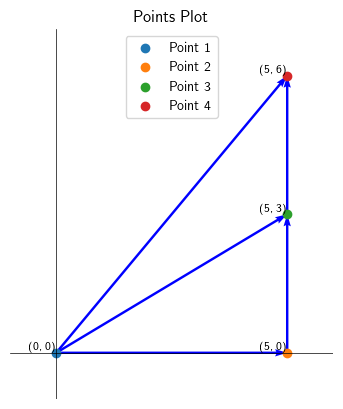

In [20]:
fig, ax = plt.subplots()
plot_vectors(C[B] ,ax=ax, margin=1)
draw_points(C, ax=ax)
plt.show()

In [ ]:
def draw_gdl(C, gdl, ax=None):
    """
    Draw vectors (vertical, horizontal, and moment) based on coordinates and degrees of freedom.

    Parameters:
    - C: numpy array of shape (n, 2)
        Array representing n points, where each point is defined by its x and y coordinates.
    - gdl: numpy array of shape (n, 3)
        Array representing n degrees of freedom for each point, where each row is [vertical, horizontal, moment].
    - ax: matplotlib.axes._subplots.AxesSubplot, optional
        Axes on which to draw the vectors. If not specified, a new figure and axes will be created.

    Returns:
    - ax: matplotlib.axes._subplots.AxesSubplot
        The AxesSubplot object on which the vectors are drawn.
    """
    if ax is None:
        fig, ax = plt.subplots()

    # Dibujar puntos
    draw_points(C, ax)

    for i, (x, y) in enumerate(C):
        # Dibujar vector vertical
        ax.quiver(x, y, 0, gdl[i, 0], angles='xy', scale_units='xy', scale=1, color='r', label=f'Vertical {i + 1}')

        # Dibujar vector horizontal
        ax.quiver(x, y, gdl[i, 1], 0, angles='xy', scale_units='xy', scale=1, color='g', label=f'Horizontal {i + 1}')

        # Dibujar momento (vector circular)
        moment_mag = 0.1  # Magnitud del momento para visualización
        ax.quiver(x, y, -gdl[i, 2] * moment_mag, gdl[i, 2] * moment_mag, angles='xy', scale_units='xy', scale=1, color='b', label=f'Moment {i + 1}')

    ax.legend()
    return ax

In [ ]:
Kk = pd.DataFrame(np.diag(GLg) @ Kg @ np.diag(GLg), index=_idx + 1, columns=_idx + 1)\
    .pipe(lambda x: x.loc[(x != 0).any(axis=0), (x != 0).any(axis=1)]).values

In [ ]:
Q = np.array([-28.206,
53.730,
71.639,
-16.327,
53.730,
0.000,
2.683,
53.730,
4.633,
-3.983,
])

# Fórmulas

$$ Q = q - MEF $$

* Desplazamientos
$$ d = Q \times K $$

* Momentos